# Pairs Datasets

In [ ]:
#| default_exp pairs

In [ ]:
#| export
import random
from typing import NamedTuple

from fastai.vision.all import *
from tqdm.auto import trange, tqdm

import fast_datasets.patches
from fast_datasets.utils import return_list

In [ ]:
#| export
class ImagePair(fastuple):
    """Adds showing functionality to fastai's `fastuple`"""
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = ToTensor()(self)
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

class Sameness(Categorize):
    """Converts boolean/binary labels into "Not Same"/"Same" labels"""
    def __init__(self):
        super().__init__(['Not Same', 'Same'], sort=False)

    def encodes(self, o: bool|int):
        return super().encodes(self.vocab[o])

In [ ]:
l = TfmdLists([False, 0, True, 1], Sameness())
test_eq([l.decode(o) for o in l], ['Not Same', 'Not Same', 'Same', 'Same'])

In [ ]:
#| exporti
@typedispatch
def show_batch(x:ImagePair, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[TensorImage](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
#| export
def _pairs_for_split(singles: DataLoaders, split_idx: int, factor: int):
    assert singles.n_inp == 1

    indices = L(range_of(singles))[singles.splits[split_idx]]
    num = int(len(indices) * factor)

    class_map = defaultdict(list)
    for i, c in tqdm(zip(indices, singles.targets.subset(split_idx)), desc='Class map: scanning targets'):
        class_map[singles.vocab[c]].append(i)

    @return_list
    def _positive_pairs():
        multi_item_class_map = {k: v for k, v in class_map.items() if len(v)>1}
        for _ in trange(num//2, desc=f'Generating positive pairs'):
            c, idxs = random.choice(list(multi_item_class_map.items()))
            yield tuple(random.sample(idxs, 2))

    @return_list
    def _negative_pairs():
        for _ in trange(num//2, desc=f'Generating negative pairs'):
            (c1, idxs1), (c2, idxs2) = random.sample(list(class_map.items()), 2)
            yield (random.choice(idxs1), random.choice(idxs2))

    return _positive_pairs() + _negative_pairs()


def Pairs(singles: Datasets,  # Used to construct pairs
          factor=10,  # ratio between numer of pairs and number of single items, for each split
          tuple_type=ImagePair  # To add `show` logic for pairs
          ) -> Datasets:
    """Fixed dataset of randomly-sampled pairs """
    assert singles.n_inp == 1
    pairs_for_splits = [_pairs_for_split(singles, i, factor) for i in range(singles.n_subsets)]

    splits = [slice(len(pairs_for_splits[0]))]
    for pairs in pairs_for_splits[1:]:
        start = splits[-1].stop
        splits.append(slice(start, start+len(pairs)))

    return Datasets(
        [L(x) for items in pairs_for_splits for x in items],
        tfms=[
            lambda o: tuple_type(singles.tls[0][o]),
            [lambda o: bool(singles.targets[o[0]] == singles.targets[o[1]]), Sameness()]
        ],
        splits=splits,
        do_setup=False,
    )

In [ ]:
from fast_datasets.mnist import TinyMNIST

In [ ]:
singles = TinyMNIST()
factor = .5
pairs = Pairs(singles, factor, ImagePair)

Class map: scanning targets: 0it [00:00, ?it/s]

Generating positive pairs:   0%|          | 0/177 [00:00<?, ?it/s]

Generating negative pairs:   0%|          | 0/177 [00:00<?, ?it/s]

Class map: scanning targets: 0it [00:00, ?it/s]

Generating positive pairs:   0%|          | 0/174 [00:00<?, ?it/s]

Generating negative pairs:   0%|          | 0/174 [00:00<?, ?it/s]

In [ ]:
for i, (idx1, idx2) in enumerate(pairs.items):
    pair, target = pairs[i]
    test_eq(pair, ImagePair(singles.tls[0][(idx1, idx2)]))
    test_eq(target, int(singles.targets[idx1] == singles.targets[idx2]))

The pairing is done separately for each subset:

In [ ]:
for singles_ss, pairs_ss in zip(singles.subsets(), pairs.subsets()):
    test_close(len(pairs_ss), len(singles_ss)*factor, 2)
    test_eq(set(pairs_ss.by_class.keys()), {'Not Same', 'Same'})
    test_eq(len(pairs.by_class['Same']), len(pairs.by_class['Not Same']))

Class map: scanning targets:   0%|          | 0/354 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/2 [00:00<?, ?it/s]

Class map: scanning targets:   0%|          | 0/702 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/2 [00:00<?, ?it/s]

Class map: scanning targets:   0%|          | 0/348 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/2 [00:00<?, ?it/s]

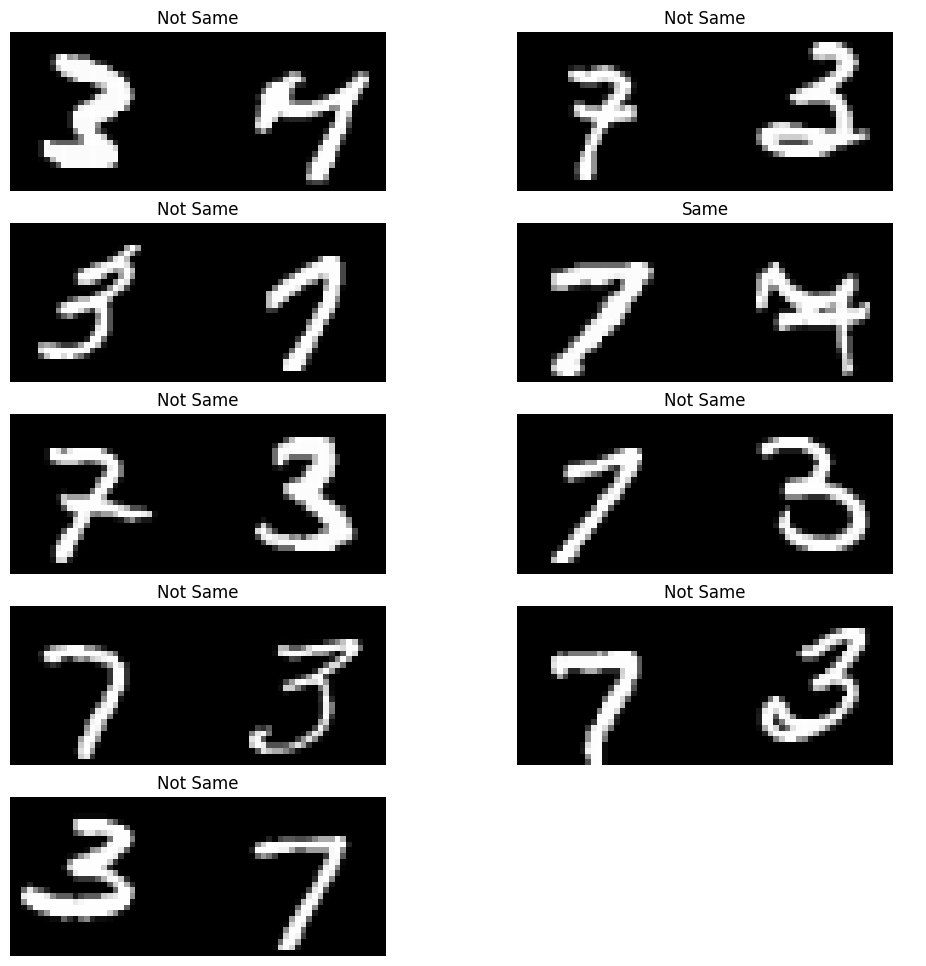

In [ ]:
pairs.dls().show_batch()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()